In [11]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)
BATCH_SIZE = 64
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count()/2)

In [39]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='./data', batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,),(0.3081)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        if stage=='fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000,5000])
        
        if stage=='test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,10,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropput(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [41]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        self.ct1 = nn.ConvTranspose2d(64,32,4,stride=2)
        self.ct2 = nn.ConvTranspose2d(32,16,4,stride=2)
        self.conv = nn.Conv2d(16,1,kernel_size=7)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = x.view(-1,64,7,7)
        x = F.relu(self.ct1(x))
        x = F.relu(self.ct2(x))
        return self.conv(x)

In [51]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # random noise 
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        # self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch

        z = torch.randn(real_imgs[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # opt_g, opt_d = self.optimizers()

        if optimizer_idx == 0:
            # opt_g.zero_grad()
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)

            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)

            g_loss = self.adversarial_loss(y_hat, y)
            self.manual_backward(g_loss)
            # opt_g.step()
            
            log_dict = {"g_loss":g_loss}
            return {"loss":g_loss, "progress_bar": log_dict, "log": log_dict}
        
        if optimizer_idx == 1:
            # opt_d.zero_grad()
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.type_as(real_imgs)

            real_loss = self.adversarial_loss(y_hat_real, y_real)
            y_hat_fake = self.discriminator(self(z).detach())
            y_fake = torch.zeros(real_imgs.size(0),1)
            y_fake = y_fake.type_as(real_imgs)

            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            d_loss = (real_loss + fake_loss) / 2
            # self.manual_backward(d_loss)
            # opt_d.step()

            log_dict = {"d_loss":d_loss}
            return {"loss":d_loss, "progress_bar": log_dict, "log": log_dict}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        print('Epoch ', self.current_epoch)
        for i in range(sample_imgs.size(0)):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i,0,:,:].tolist(), cmap='gray_r', interpolation='none')
            plt.title('Generated Data')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()
    
    def on_epoch_end(self):
        self.plot_imgs()

Epoch  0


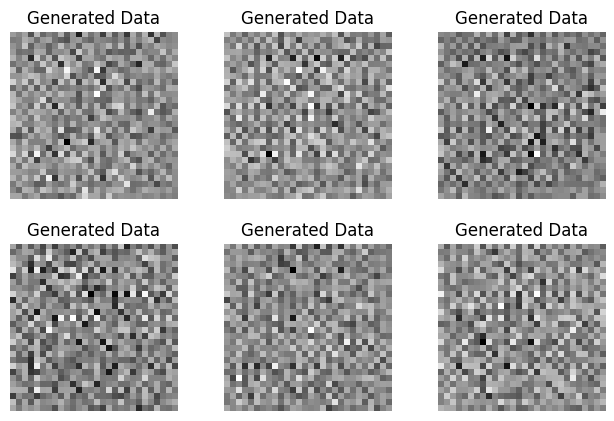

In [52]:
dm = MNISTDataModule()
model = GAN()
model.plot_imgs()

In [53]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\robot\anaconda3\envs\gan_env\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


RuntimeError: Training with multiple optimizers is only supported with manual optimization. Remove the `optimizer_idx` argument from `training_step`, set `self.automatic_optimization = False` and access your optimizers in `training_step` with `opt1, opt2, ... = self.optimizers()`.